Goals:

    To build and evaluate the performance of a linear classification model. Please, provide the accuracy, sensitivity, specificity and probability distributions on the training, validation and tests datasets. Discuss any potential differences between the datasets.
    To build and evaluate the performance of a fully connected neural network with:
        Only one layer of perceptrons
        More than one layer of perceptrons

Please, provide the accuracy, sensitivity, specificity and probability distributions on the training, validation and tests datasets. Discuss any potential differences between the datasets.

Quantify and discuss the differences in performance between the linear classification model, the neural network with one single layer and the more complex neural network. Please, provide clear explanations about the observed differences and similarities.

Note: support your discussion with plots and graphic representations when possible.

In [1]:
# remove the first sigmoid layer
# test logistic regression
# delete your previous model logs to have tensorboard look nice

# tensor cmd: tensorboard --logdir log/MyNetwork

In [43]:
import numpy as np
import pandas as pd
import scipy
import shelve
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import category_encoders as ce
import seaborn as sns
from scipy.stats import normaltest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.optimize import minimize
from scipy.stats import shapiro
from scipy.special import expit
from sklearn import svm
import shelve

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import itertools
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import confusion_matrix

import torch
from MyNetwork import MyNetwork

In [3]:
#training_data = pd.read_excel("./GeneExpressionCancer_training.xlsx").to_numpy()
#validation_data = pd.read_excel("./GeneExpressionCancer_validation.xlsx").to_numpy()
#testing_data = pd.read_excel("./GeneExpressionCancer_test.xlsx").to_numpy()

In [125]:
# Load data
trainingData = pd.read_excel('GeneExpressionCancer_training.xlsx').to_numpy()
validationData = pd.read_excel('GeneExpressionCancer_validation.xlsx').to_numpy()

# train+validate labels and features
trainPlusValidate = np.vstack([trainingData.copy(), validationData.copy()])
trainPlusValidateLabels = trainPlusValidate[:, -1]
trainPlusValidate = trainPlusValidate[:, :-1]

# train labels and features
trainingLabels = trainingData[:, -1]
trainingData = trainingData[:, :-1]

# validation labels and features
validationLabels = validationData[:, -1]
validationData = validationData[:, :-1]

# test data labels and features
testData = pd.read_excel('GeneExpressionCancer_test.xlsx').to_numpy()
testLabels = testData[:, -1]
testData = testData[:, :-1]

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
trainingData = scaler.fit_transform(trainingData)
validationData = scaler.transform(validationData)
testData = scaler.transform(testData)
# i'm too lazy, but there should be a different scaler for the lr datasets
# 1. fit and transform on trainPlusValidate
# 2. transform test
# but then I would need to keep track of different datasets between the models and that's too much work
trainPlusValidate = scaler.transform(trainPlusValidate)

In [132]:
def get_truth_indices_for_pos_and_neg(list_truth):
    idx_pos = []
    idx_neg = []
    for i,t in enumerate(list_truth):
        if t == 1:
            idx_pos.append(i)
        elif t == 0:
            idx_neg.append(i)
        else:
            raise ValueError
    return(
        {'idx_pos': idx_pos, 'idx_neg': idx_neg}
    )
#dict_idx_truth_classes = get_truth_indices_for_pos_and_neg(trainingLabels)

In [133]:
# fit logistic regression with train+validate
lr = LogisticRegression()
lr.fit(X=trainPlusValidate, y=trainPlusValidateLabels)

LogisticRegression()

In [145]:
def lr_predict_and_plot_perf(data, truth, model , plot_type, title = 'Prediction performance'):
    p_1 = model.predict_proba(data)[:, -1]
    y_pred = model.predict(data)
    fpr, tpr, thres = sklearn.metrics.roc_curve(truth, p_1, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(truth, y_pred).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (fn+tp)
    accuracy = (tn + tp) / (tn+tp+fn+fp)
    auroc = round(roc_auc_score(truth, p_1),3)
    if plot_type == 'AUROC':
        plt.plot(fpr, tpr) #avg_acc={avg_acc}; avg_f1={avg_f1}')
        plt.xlabel("FPR (False Positive Rate)")
        plt.ylabel("TPR (True Positive Rate)")
        plt.title(title)
        plt.text(x = 0.6, y= 0.5, s = f'accuracy={round(accuracy, 4)}')
        plt.text(x = 0.6, y= 0.4, s = f'sensitivity={round(sensitivity, 4)}')
        plt.text(x = 0.6, y= 0.3, s = f'specificity={round(specificity, 4)}')
        plt.text(x = 0.6, y= 0.2, s = f'AUROC={round(auroc, 4)}')
        plt.legend()
        plt.show()
    elif plot_type == 'Distributions':
        truth_indices = get_truth_indices_for_pos_and_neg(truth)
        neg_samples = [p_1[i] for i in truth_indices['idx_neg']]
        pos_samples = [p_1[i] for i in truth_indices['idx_pos']]
        plt.hist(neg_samples, alpha = 0.5, color = 'red')
        plt.hist(pos_samples, alpha = 0.5, color = 'blue')
        plt.legend(['Class 0 probability', 'Class 1 probability'])
        plt.title(title)
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


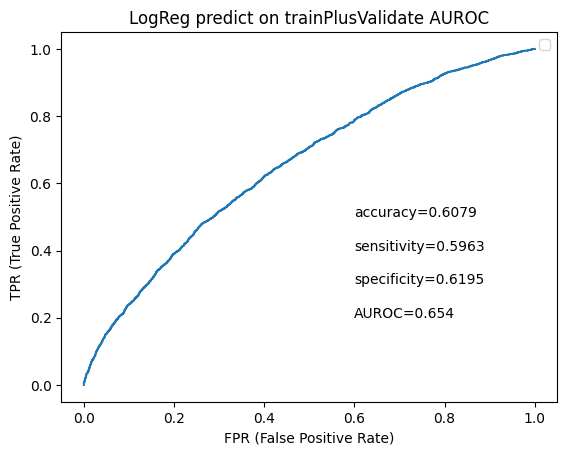

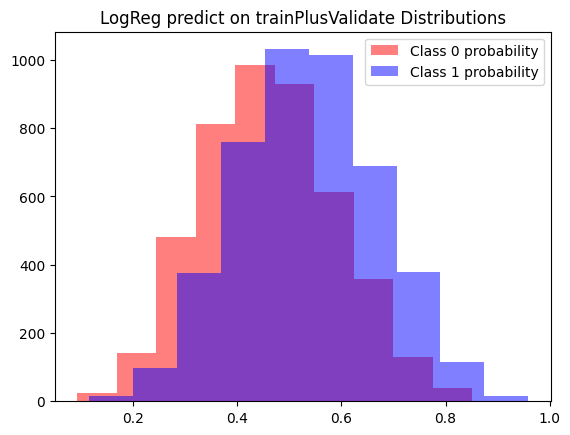

In [149]:
# logistic regression
# predict on trainPlusValidate
lr_predict_and_plot_perf(trainPlusValidate, trainPlusValidateLabels, model = lr, plot_type='AUROC', title = "LogReg predict on trainPlusValidate AUROC")
lr_predict_and_plot_perf(trainPlusValidate, trainPlusValidateLabels, model = lr, plot_type='Distributions', title = "LogReg predict on trainPlusValidate Distributions")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


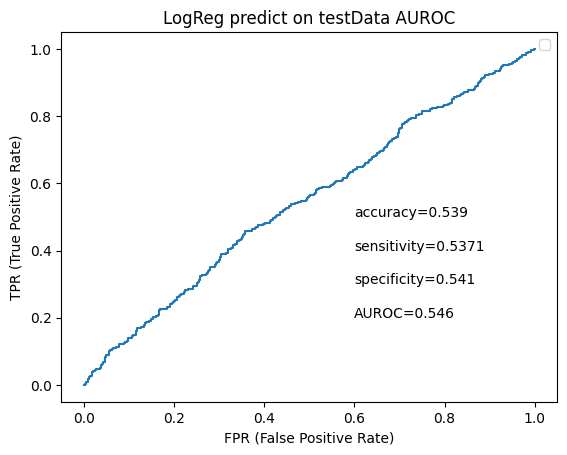

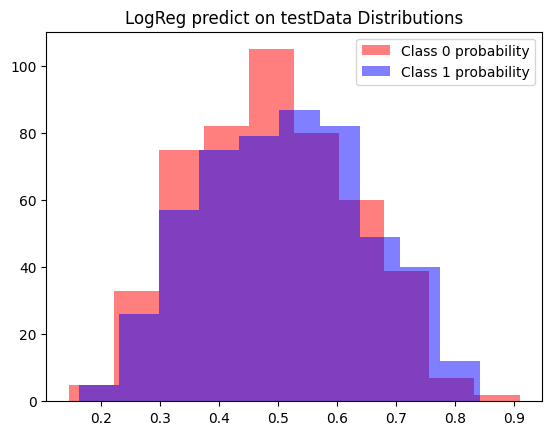

In [150]:
# logistic regression
# predict on test data
lr_predict_and_plot_perf(testData, testLabels, model = lr, plot_type='AUROC', title = "LogReg predict on testData AUROC")
lr_predict_and_plot_perf(testData, testLabels, model = lr, plot_type='Distributions', title = "LogReg predict on testData Distributions")

## Neural Network

Reload data because I'm too lazy to change names

In [88]:
# load trained model
model_2_layer = torch.load('./model/FinalModel_2_layer')
model_1_layer = torch.load('./model/FinalModel_1_layer')

In [151]:
# predict on train

def nn_predict_and_plot_perf(
        data, truth, model, 
        title = 'AUROC', plot_type = 'AUROC', verbose = False
    ):
    y_pred_prob = model.predict(data)
    y_pred = y_pred_prob.copy()
    y_pred[y_pred >= 0.5] = 1
    y_pred[y_pred < 0.5] = 0
    if verbose:
        for p, c in zip(y_pred_prob, y_pred):
            print(f'prob: {p}; class: {c}')
    fpr, tpr , thres = sklearn.metrics.roc_curve(truth, y_pred_prob)
    tn, fp, fn, tp = confusion_matrix(truth, y_pred).ravel()
    specificity = round(tn / (tn+fp), 3)
    sensitivity = round(tp / (fn+tp), 3)
    accuracy = round((tn + tp) / (tn+tp+fn+fp), 3)
    auroc = round(roc_auc_score(truth, y_pred_prob),3)
    if plot_type == 'AUROC':
        plt.plot(fpr, tpr)
        plt.title(title, weight = 'bold')
        plt.text(x = 0.6, y = 0.5, s = f'accuracy: {accuracy}')
        plt.text(x = 0.6, y = 0.4, s = f'sensitivity: {sensitivity}')
        plt.text(x = 0.6, y = 0.3, s = f'specificity: {specificity}')
        plt.text(x = 0.6, y = 0.2, s = f'AUROC: {auroc}')
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.show()

    elif plot_type == 'Distributions':
        truth_classes = get_truth_indices_for_pos_and_neg(truth)
        p_neg = [y_pred_prob[i] for i in truth_classes['idx_neg']]
        p_pos = [y_pred_prob[i] for i in truth_classes['idx_pos']]
        plt.hist(p_neg, alpha = 0.5, color = 'red')
        plt.hist(p_pos, alpha = 0.5, color = 'blue')
        plt.title(title)
        plt.legend(['Class 0 probability', "Class 1 probability"])
        plt.show()
    else:
        raise ValueError



/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


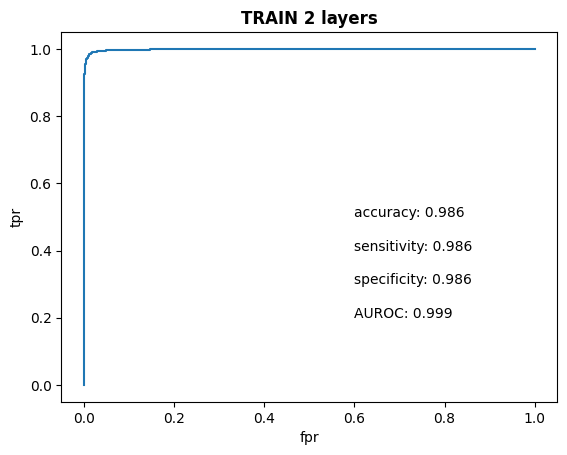

/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


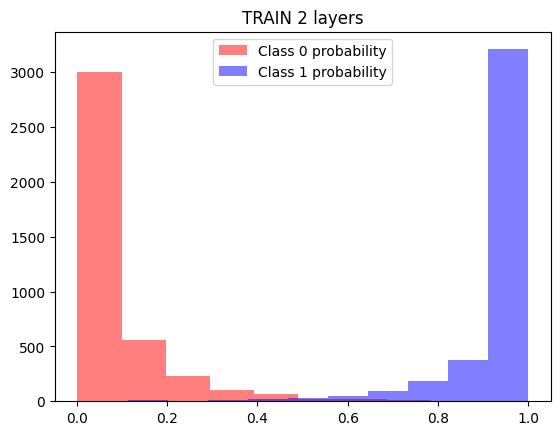

In [152]:
# predict training; 2 layers
nn_predict_and_plot_perf(
    trainingData,
    trainingLabels,
    model = model_2_layer,
    plot_type= 'AUROC',
    title='TRAIN 2 layers'
)
nn_predict_and_plot_perf(
    trainingData,
    trainingLabels,
    model = model_2_layer,
    plot_type= 'Distributions',
    title='TRAIN 2 layers'
)


/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


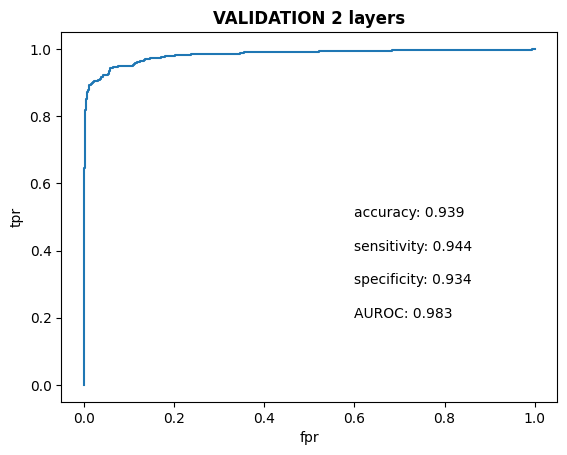

/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


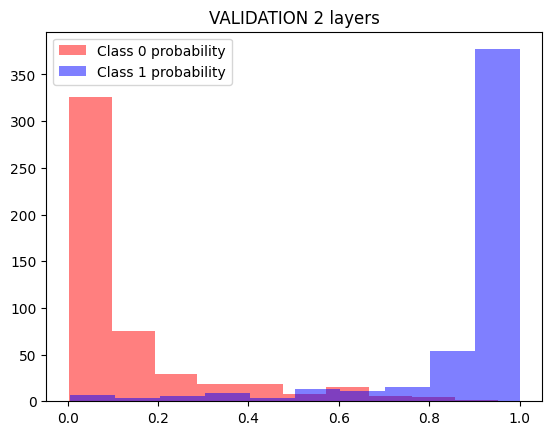

In [153]:
# validation; 2 layers
nn_predict_and_plot_perf(
    validationData,
    validationLabels,
    model = model_2_layer,
    plot_type='AUROC',
    title = 'VALIDATION 2 layers'
)
nn_predict_and_plot_perf(
    validationData,
    validationLabels,
    model = model_2_layer,
    plot_type='Distributions',
    title = 'VALIDATION 2 layers'
)

/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


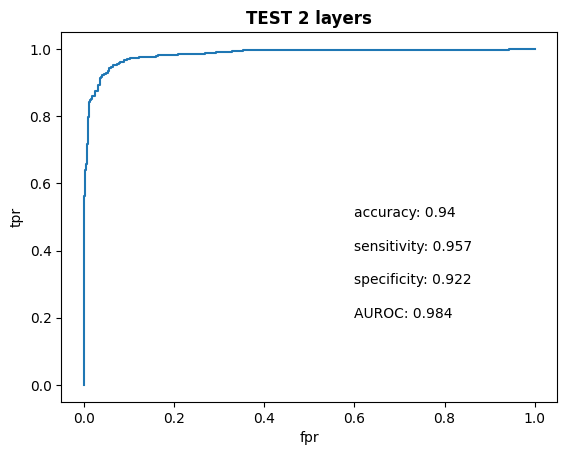

/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


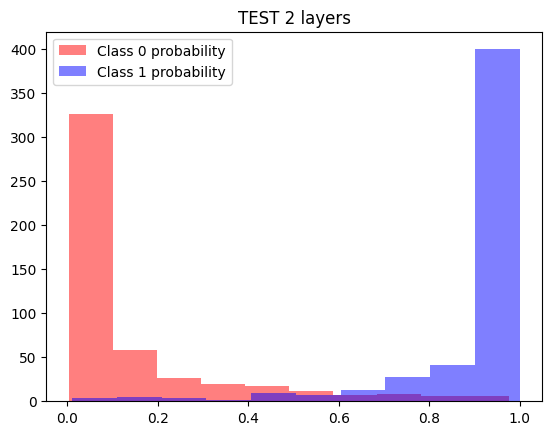

In [154]:
nn_predict_and_plot_perf(
    testData,
    testLabels, 
    model = model_2_layer,
    plot_type='AUROC',
    title = 'TEST 2 layers')
nn_predict_and_plot_perf(
    testData,
    testLabels, 
    model = model_2_layer,
    plot_type='Distributions',
    title = 'TEST 2 layers')

/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


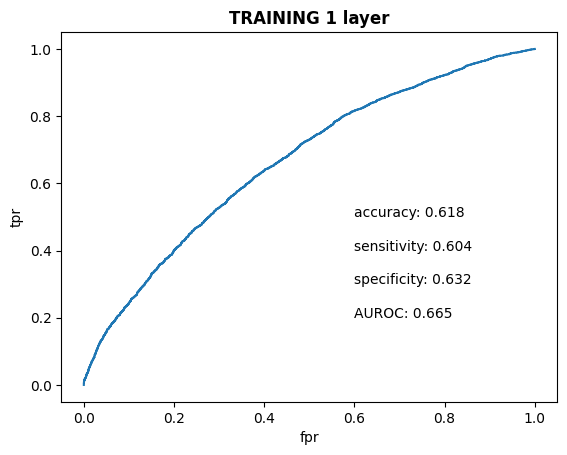

/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


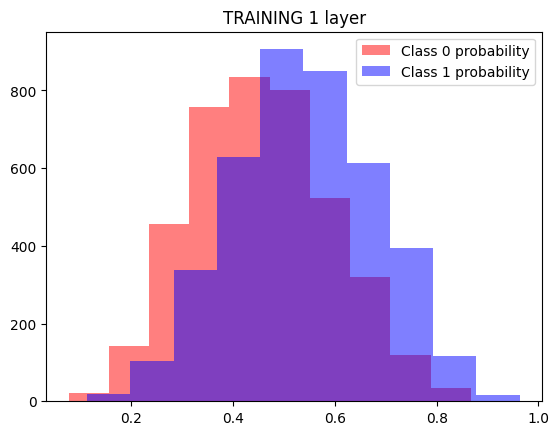

In [155]:
nn_predict_and_plot_perf(
    data = trainingData,
    truth= trainingLabels,
    model = model_1_layer,
    plot_type='AUROC',
    title = 'TRAINING 1 layer'
)
nn_predict_and_plot_perf(
    data = trainingData,
    truth= trainingLabels,
    model = model_1_layer,
    plot_type='Distributions',
    title = 'TRAINING 1 layer'
)

/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


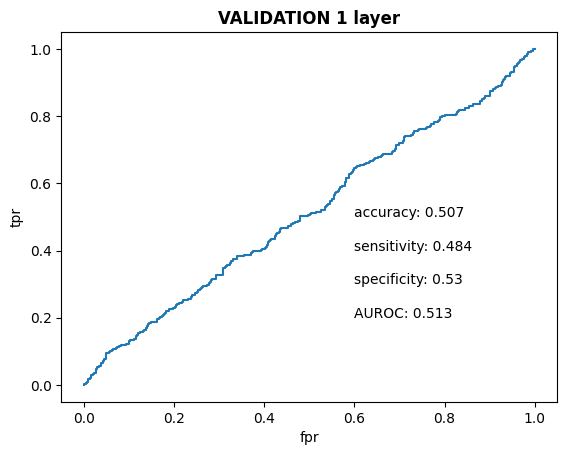

/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


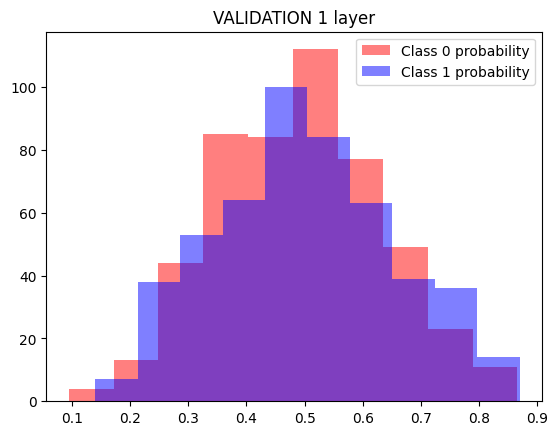

In [156]:
# validation 1 layer
nn_predict_and_plot_perf(
    data = validationData,
    truth= validationLabels,
    model = model_1_layer,
    title = 'VALIDATION 1 layer'
)
nn_predict_and_plot_perf(
    data = validationData,
    truth= validationLabels,
    model = model_1_layer,
    plot_type='Distributions',
    title = 'VALIDATION 1 layer'
)

/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


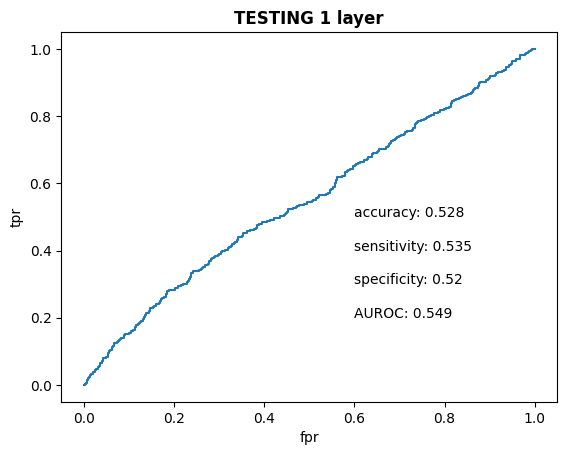

/home/jake/ghub/bios_7747/MyNetwork.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


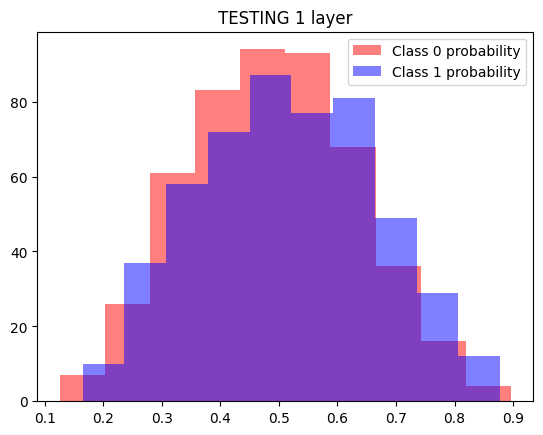

In [157]:
# test 1 layer
nn_predict_and_plot_perf(
    data = testData,
    truth= testLabels,
    model = model_1_layer,
    plot_type='AUROC',
    title = 'TESTING 1 layer'
)
nn_predict_and_plot_perf(
    data = testData,
    truth= testLabels,
    model = model_1_layer,
    plot_type='Distributions',
    title = 'TESTING 1 layer'
)